# Initialization

In [1]:
import numpy as np
from mpmath import mp
from matplotlib import pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import time
from IPython.display import Image
from tqdm.notebook import tqdm
plt.rcParams.update({'font.size': 15})

In [2]:
mu0 = 4e-7*np.pi
c0 = 299792458
eps0 = 1/(c0**2*mu0)
hbar = 1.05457182e-34
kb = 1.380649e-23

In [3]:
#$\mu$ is dipole matrix element. This is set to e*1.3nm in the paper
mu = 1.60217663e-19*1.3e-9
#Lc is the total length of the 1d photonic lattice
Lc = 1.2e-4
#Lr is the total length of the system including the vaccum part.
Lr = 0.012
#Np is the number of periods of the photonic lattices.
Np = 12
#lp is the length of one period.
lp = Lc/Np
#L is the normalized total length
L = np.round(Lr/lp)
#gamma is polarization decay rate
gamma = 1e12 
kb_normal = kb/(gamma**2)
hbar_normal = hbar/gamma
gamma_d = 5e11/gamma

In [14]:
def fa(omega_n,T):
    return 1/(1+np.exp(-hbar_normal*omega_n/(kb_normal*T)))
def fb(omega_n,T):
    return np.exp(-hbar_normal*omega_n/(kb_normal*T))/(1+np.exp(-hbar_normal*omega_n/(kb_normal*T)))             

## Initialization for spectrum figures

In [4]:
def Swk_gen(omega_l, Omega_k, G_factor):
    nw = len(Omega_k)
    Swk = []
    for omega in omega_l:
        Swk.append(Omega_k*G_factor*gamma_d/(gamma_d**2 + (omega*np.ones(nw) - Omega_k)**2))
    return np.array(Swk)

In [5]:
def S_io(omega_l, Omega_k, G_in, G_out, Nk):
    s_in = []
    s_out = []
    Swk_in = Swk_gen(omega_l, Omega_k, G_in)
    Swk_out = Swk_gen(omega_l, Omega_k, G_out)
    for i, omega in enumerate(omega_l):
        s_in.append(np.sum(Swk_in[i]*Nk))
    for i, omega in enumerate(omega_l):
        s_out.append(np.sum(Swk_out[i]*Nk))
    return np.array(s_in), np.array(s_out)                    

In [6]:
def Nk_load(emode_f, photon_f):
    emodes = np.load(emode_f)
    ks = emodes["ks"]
    G_in = emodes["G_in"]
    G_out = emodes["G_out"]
    G_out_ep = emodes["G_out_ep"]
    Omega_k = ks/lp*c0/gamma
    nit = np.load(photon_f)
    try:
        Nk = nit["Nk"]
    except:
        Nk = nit['Nkt']
    if Nk.ndim != 1:
        Nk = Nk[-1]
    return Omega_k, G_in, G_out, G_out_ep, Nk

In [7]:
def plot_s_omega(omega_l, emodes_files, PN_files, labels, IN_OUT, xlabel, ylabel, title, picture_files, 
                 xlim=None, ylim=None, yscale=False, logyscale=False):
    for i, emodes_f in enumerate(emodes_files):
        Omega_k, G_in, G_out, G_out_ep, Nk = Nk_load(emodes_f,PN_files[i])
        s_in, s_out = S_io(omega_l, Omega_k, G_in, G_out_ep, Nk)
        if IN_OUT == 'IN':
            if yscale:
                plt.plot(omega_l, s_in/1000, label = labels[i])
            else:
                plt.plot(omega_l, s_in, label = labels[i])
        else:
            if yscale:
                plt.plot(omega_l, s_out/1000, label = labels[i])
            else:
                plt.plot(omega_l, s_out, label = labels[i])
    ax = plt.gca()
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim == None and ylim == None:
        ax.autoscale_view()
    plt.xlabel(xlabel)
    if yscale:
        plt.ylabel(ylabel + '/1000')
    else:
        plt.ylabel(ylabel)
    if logyscale:
        plt.yscale('log')
    plt.title(title)
    plt.grid()
    plt.legend(loc=1, prop={'size': 13})
    plt.savefig(picture_files, dpi=300)
    plt.show()

# Figure 6

In [6]:
Tp=mp.mpf('0.01')
low_kb = 0
high_kb = 6*mp.pi
eta_eff = 2*mp.sqrt((1-Tp)/Tp)    
kbar = (low_kb + high_kb)/2
Lam = eta_eff/kbar

In [7]:
def uk_coef_mp(kl, Lam=Lam, Np=Np):
    eta = Lam*kl
    i00 = mp.mpf(1)+1j/2*eta
    i11 = mp.mpf(1)-1j/2*eta
    M_p = mp.matrix([[mp.expj(kl),0],[0,mp.expj(-kl)]])
    M_i = mp.matrix([[i00, 1j/2*eta],[-1j/2*eta, i11]])
    u_i = mp.matrix([[mp.mpc(1/2j)],[mp.mpc(-1/2j)]])
    uk_coef = [[mp.mpc(1/2j),mp.mpc(-1/2j)]]
    for i in range(Np):
        u_i = (M_i * M_p)*u_i
        uk_coef.append([u_i[0],u_i[1]])
    return uk_coef  

In [17]:
def ukz_mp(k, z, ukn):
    if z > Np:
        n = Np
        zext = z-Np
    else:
        n = int(mp.floor(z))
        zext = mp.fmod(z,1)
    return ukn[n][0]*mp.expj(k*zext) + ukn[n][1]*mp.expj(-k*zext)
def uk_f(z):
    return mp.re(ukz_mp(ktest, z, ukn))

In [14]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

In [16]:
print(Omega_k[1200])
print(Omega_k[1400])
print(Omega_k[1500])

94.25040937704107531
109.196185668677594086
117.09765795786541392


In [23]:
ktest = ks[1200]
ukn = uk_coef_mp(ktest,Lam,Np)
zl = mp.linspace(0,1200,50000)
ukfl = []
for z in zl:
    ukfl.append(uk_f(z))
ukfl = np.array(ukfl)

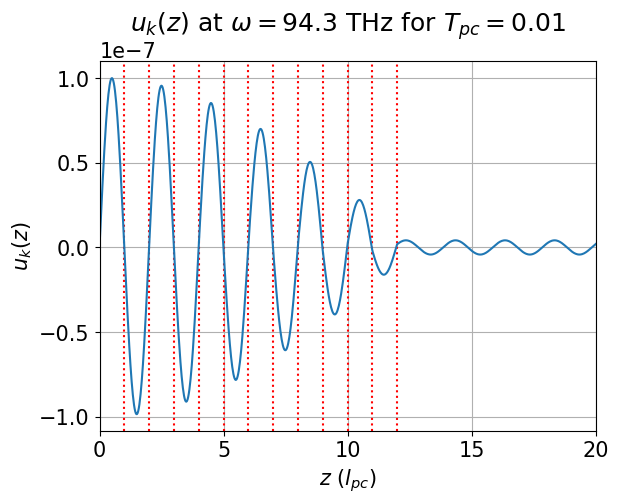

In [25]:
plt.xlim(0,20)
plt.title(r"$u_k(z)$ at $\omega=94.3$ THz for $T_{pc}=0.01$")
plt.xlabel(r'$z$ ($l_{pc}$)')
plt.ylabel(r'$u_k(z)$')
plt.axvline(1,ls=':',color='r')
plt.axvline(2,ls=':',color='r')
plt.axvline(3,ls=':',color='r')
plt.axvline(4,ls=':',color='r')
plt.axvline(5,ls=':',color='r')
plt.axvline(6,ls=':',color='r')
plt.axvline(7,ls=':',color='r')
plt.axvline(8,ls=':',color='r')
plt.axvline(9,ls=':',color='r')
plt.axvline(10,ls=':',color='r')
plt.axvline(11,ls=':',color='r')
plt.axvline(12,ls=':',color='r')
plt.grid()
plt.plot(zl,ukfl/1e7)
#plt.savefig("./Graphs/ukz_1_tp001.png", dpi=300)
plt.show()

In [20]:
ktest = ks[1400]
ukn = uk_coef_mp(ktest,Lam,Np)
zl = mp.linspace(0,1200,50000)
ukfl = []
for z in zl:
    ukfl.append(uk_f(z))
ukfl = np.array(ukfl)

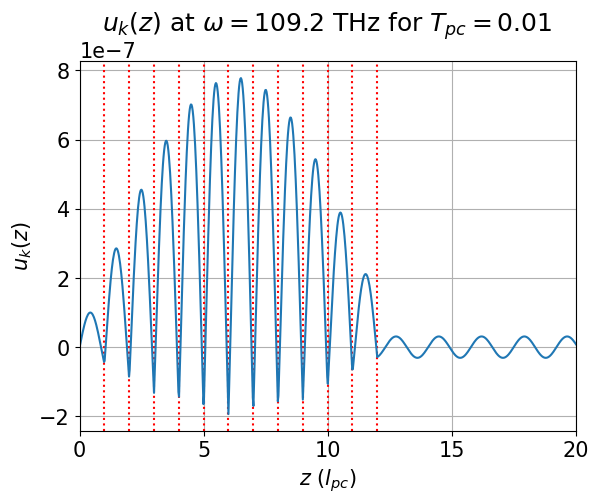

In [22]:
plt.xlim(0,20)
plt.title(r"$u_k(z)$ at $\omega=109.2$ THz for $T_{pc}=0.01$")
plt.xlabel(r'$z$ ($l_{pc}$)')
plt.ylabel(r'$u_k(z)$')
plt.axvline(1,ls=':',color='r')
plt.axvline(2,ls=':',color='r')
plt.axvline(3,ls=':',color='r')
plt.axvline(4,ls=':',color='r')
plt.axvline(5,ls=':',color='r')
plt.axvline(6,ls=':',color='r')
plt.axvline(7,ls=':',color='r')
plt.axvline(8,ls=':',color='r')
plt.axvline(9,ls=':',color='r')
plt.axvline(10,ls=':',color='r')
plt.axvline(11,ls=':',color='r')
plt.axvline(12,ls=':',color='r')
plt.grid()
plt.plot(zl,ukfl/1e7)
#plt.savefig("./Graphs/ukz_2_tp001.png", dpi=300)
plt.show()

In [18]:
ktest = ks[1500]
ukn = uk_coef_mp(ktest,Lam,Np)
zl = mp.linspace(0,1200,50000)
ukfl = []
for z in zl:
    ukfl.append(uk_f(z))
ukfl = np.array(ukfl)

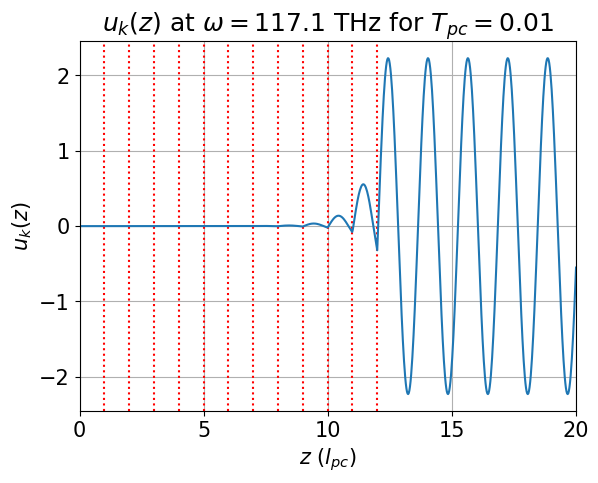

In [19]:
plt.xlim(0,20)
plt.title(r"$u_k(z)$ at $\omega=117.1$ THz for $T_{pc}=0.01$")
plt.xlabel(r'$z$ ($l_{pc}$)')
plt.ylabel(r'$u_k(z)$')
plt.axvline(1,ls=':',color='r')
plt.axvline(2,ls=':',color='r')
plt.axvline(3,ls=':',color='r')
plt.axvline(4,ls=':',color='r')
plt.axvline(5,ls=':',color='r')
plt.axvline(6,ls=':',color='r')
plt.axvline(7,ls=':',color='r')
plt.axvline(8,ls=':',color='r')
plt.axvline(9,ls=':',color='r')
plt.axvline(10,ls=':',color='r')
plt.axvline(11,ls=':',color='r')
plt.axvline(12,ls=':',color='r')
plt.grid()
plt.plot(zl,ukfl/1e7)
#plt.savefig("./Graphs/ukz_3_tp001.png", dpi=300)
plt.show()

# Figure 7

In [117]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

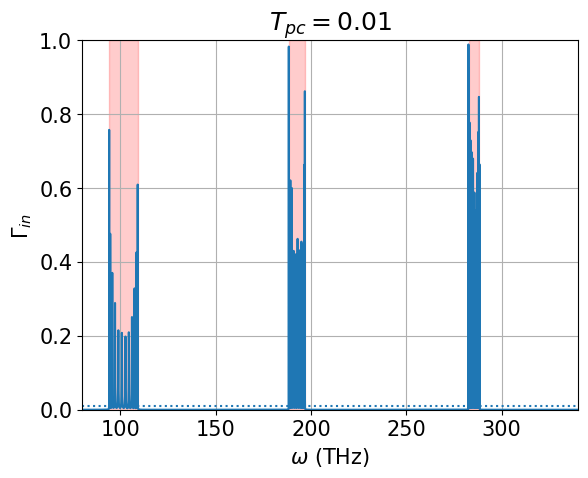

In [123]:
plt.xlim(80, 340)
plt.ylim(0,1)
plt.title(r"$T_{pc}=0.01$")

plt.axvspan(94.25,109.2,color='red',alpha=0.2)
plt.axvspan(188.4,196.8,color='red',alpha=0.2)
plt.axvspan(282.6,288.3,color='red',alpha=0.2)

plt.ylabel(r"$\Gamma_{in}$")
plt.xlabel(r"$\omega$ (THz)")
plt.axhline(0.01,ls=':')
plt.plot(Omega_k, G_in)
plt.grid()
#plt.savefig("./Graphs/G_in_tp001_bands.png",dpi=300)
plt.show()

In [125]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

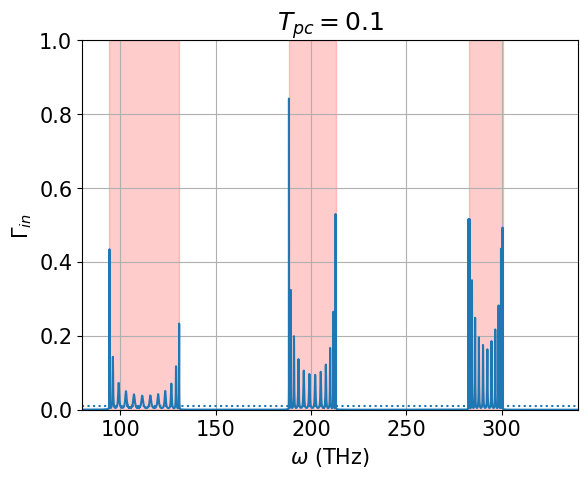

In [127]:
plt.xlim(80, 340)
plt.ylim(0,1)
plt.title(r"$T_{pc}=0.1$")

plt.axvspan(94.25,130.9,color='red',alpha=0.2)
plt.axvspan(188.25,212.9,color='red',alpha=0.2)
plt.axvspan(282.6,300.5,color='red',alpha=0.2)

plt.ylabel(r"$\Gamma_{in}$")
plt.xlabel(r"$\omega$ (THz)")
plt.axhline(0.01,ls=':')
plt.plot(Omega_k, G_in)
plt.grid()
#plt.savefig("./Graphs/G_in_tp01_Nkt_modes_indicate.png",dpi=300)
plt.show()

In [128]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

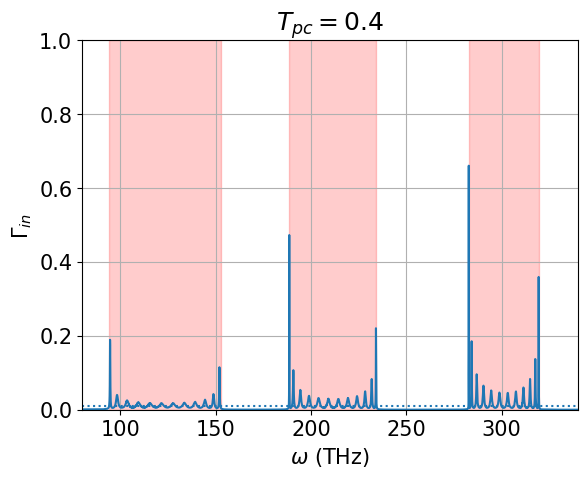

In [129]:
plt.xlim(80, 340)
plt.ylim(0,1)
plt.title(r"$T_{pc}=0.4$")

plt.axvspan(94.25,152.6,color='red',alpha=0.2)
plt.axvspan(188.25,234.1,color='red',alpha=0.2)
plt.axvspan(282.6,319.4,color='red',alpha=0.2)

plt.ylabel(r"$\Gamma_{in}$")
plt.xlabel(r"$\omega$ (THz)")
plt.axhline(0.01,ls=':')
plt.plot(Omega_k, G_in)
plt.grid()
#plt.savefig("./Graphs/G_in_tp01_Nkt_modes_indicate.png",dpi=300)
plt.show()

# Figure 8

In [27]:
disp = np.load("./Data/dispersion_tpc001.npz")
k_l_001 = disp["k_l"]
g_peak_001 = disp["g_peak"]
disp = np.load("./Data/dispersion_tpc01.npz")
k_l_01 = disp["k_l"]
g_peak_01 = disp["g_peak"]
disp = np.load("./Data/dispersion_tpc04.npz")
k_l_04 = disp["k_l"]
g_peak_04 = disp["g_peak"]

In [28]:
dk_do_001 = []
dk_do_01 = []
dk_do_04 = []
for i in range(len(k_l_001)):
    if i+1 < len(k_l_001) and (i+1)%12 !=0 :
        dk_do_001.append((k_l_001[i+1]-k_l_001[i])/(g_peak_001[i+1]-g_peak_001[i]))
for i in range(len(k_l_01)):
    if i+1 < len(k_l_01) and (i+1)%12 !=0 :
        dk_do_01.append((k_l_01[i+1]-k_l_01[i])/(g_peak_01[i+1]-g_peak_01[i]))
for i in range(len(k_l_04)):
    if i+1 < len(k_l_04) and (i+1)%12 !=0 :
        dk_do_04.append((k_l_04[i+1]-k_l_04[i])/(g_peak_04[i+1]-g_peak_04[i]))
dk_do_001 = np.array(dk_do_001 )
dk_do_01 = np.array(dk_do_01 )
dk_do_04 = np.array(dk_do_04 )
dk_do_001 = dk_do_001*12*np.double(lp)/np.pi
dk_do_01 = dk_do_01*12*np.double(lp)/np.pi
dk_do_04 = dk_do_04*12*np.double(lp)/np.pi

In [29]:
kl_n_001=k_l_001*np.double(lp)/(2*np.pi)
g_peak_n_001 = g_peak_001*np.double(lp)/(2*np.pi*np.double(c0))
kl_n_01=k_l_01*np.double(lp)/(2*np.pi)
g_peak_n_01 = g_peak_01*np.double(lp)/(2*np.pi*np.double(c0))
kl_n_04=k_l_04*np.double(lp)/(2*np.pi)
g_peak_n_04 = g_peak_04*np.double(lp)/(2*np.pi*np.double(c0))

In [30]:
kl_n_red_001 = np.hstack((kl_n_001[:12]*(-1)+1, kl_n_001[12:24]-1, kl_n_001[24:]*(-1)+2))
kl_n_red_01 = np.hstack((kl_n_01[:12]*(-1)+1, kl_n_01[12:24]-1, kl_n_01[24:]*(-1)+2))
kl_n_red_04 = np.hstack((kl_n_04[:12]*(-1)+1, kl_n_04[12:24]-1, kl_n_04[24:]*(-1)+2))

In [31]:
omega_n_001 = []
omega_n_01 = []
omega_n_04 = []
for i in range(len(g_peak_n_001)):
    if i+1 < len(g_peak_n_001) and (i+1)%12 !=0 :
        omega_n_001.append((g_peak_n_001[i+1]+g_peak_n_001[i])/2)
for i in range(len(g_peak_n_01)):
    if i+1 < len(g_peak_n_01) and (i+1)%12 !=0 :
        omega_n_01.append((g_peak_n_01[i+1]+g_peak_n_01[i])/2)
for i in range(len(g_peak_n_04)):
    if i+1 < len(g_peak_n_04) and (i+1)%12 !=0 :
        omega_n_04.append((g_peak_n_04[i+1]+g_peak_n_04[i])/2)
omega_n_001 = np.array(omega_n_001)
omega_n_01 = np.array(omega_n_01)
omega_n_04 = np.array(omega_n_04)

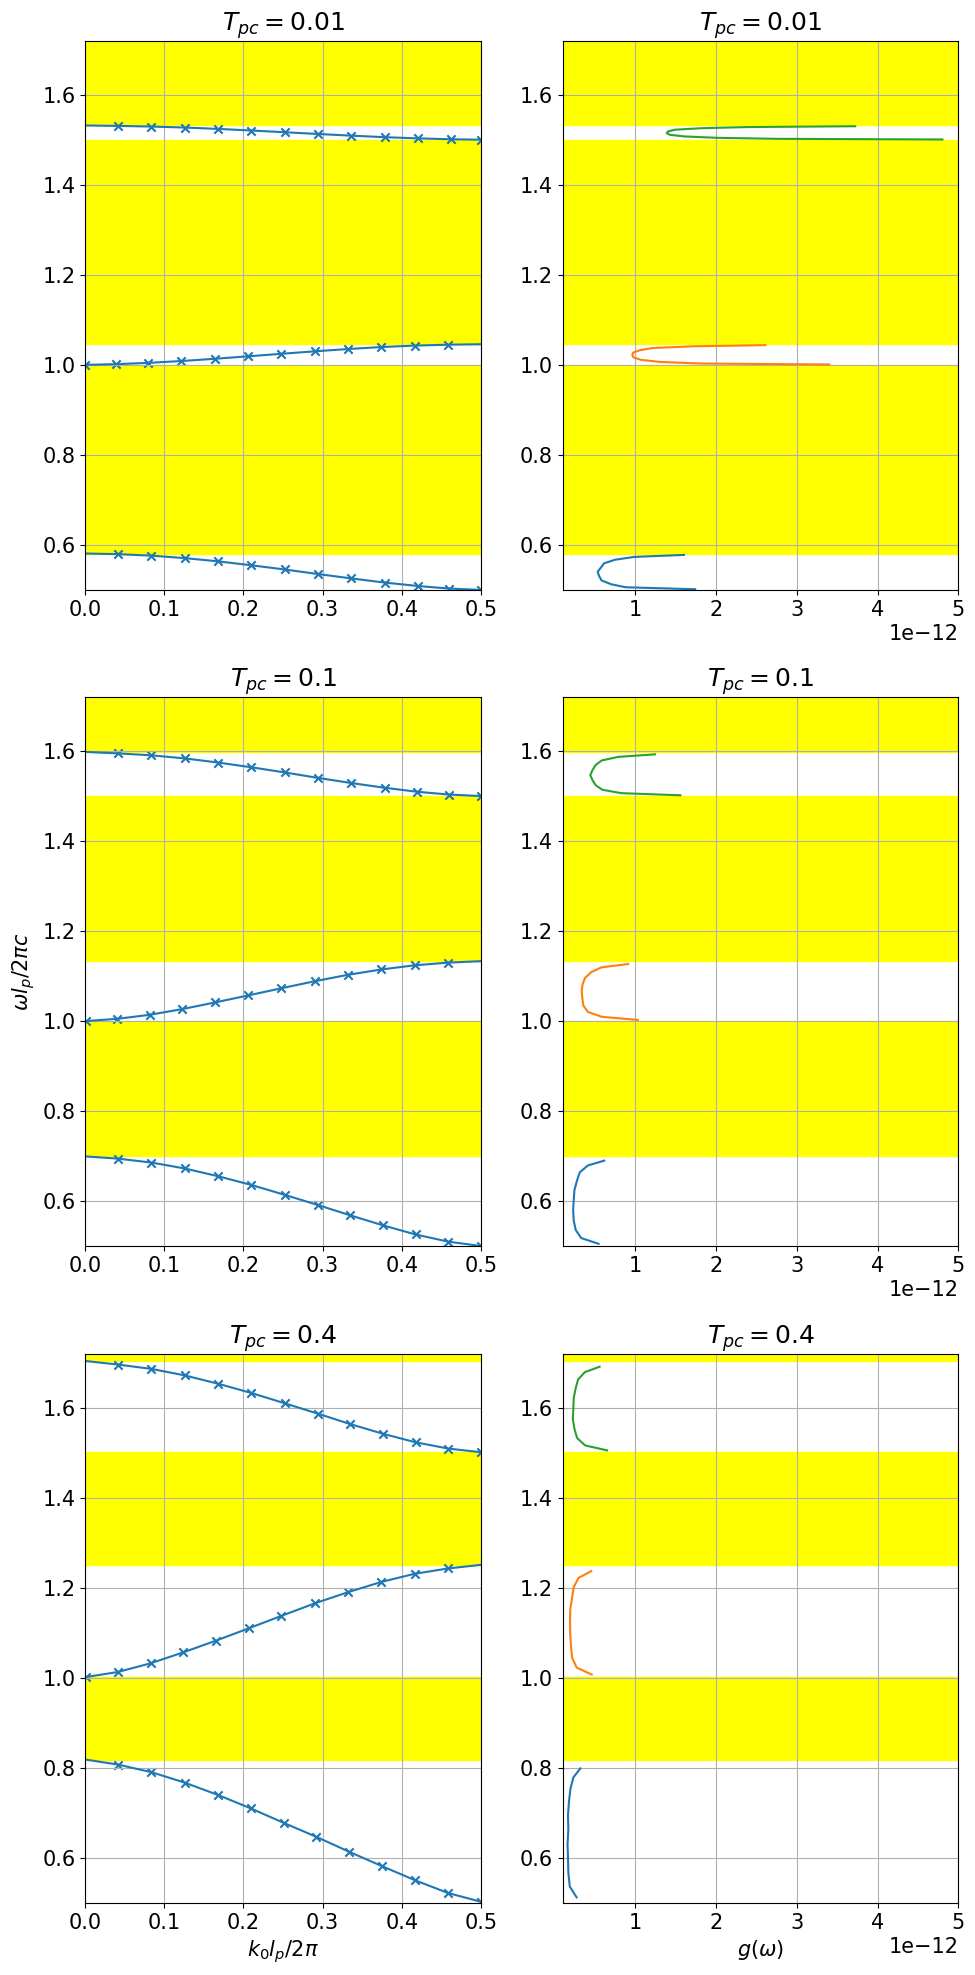

In [32]:
#fig, axs = plt.subplots(3, 1, figsize=(10, 20)) 
fig = plt.figure(figsize=(10, 20))
ax1 = plt.subplot(321)
plt.xlim(0,0.5)
plt.ylim(0.5,1.72)
kl_n_1 = kl_n_001[:12]*(-1)+1
kl_n_2 = kl_n_001[12:24]-1
kl_n_3 = kl_n_001[24:]*(-1)+2
#plt.xlabel(r"$k_0 l_p/2\pi$")
#plt.ylabel(r"$\omega l_p/2\pi c$")
plt.title(r"$T_{pc}=0.01$")
plt.grid()
end1 = g_peak_n_001[11]+(g_peak_n_001[13]-g_peak_n_001[12])
end2 = g_peak_n_001[23]+(g_peak_n_001[25]-g_peak_n_001[24])
end3 = g_peak_n_001[-1]+(g_peak_n_001[25]-g_peak_n_001[24])
plt.axhspan(end1, g_peak_n_001[12], color='yellow')
plt.axhspan(end2, g_peak_n_001[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.plot(np.append(kl_n_1, 0), np.append(g_peak_n_001[:12], end1))
plt.plot(np.append(kl_n_2, 0.5), np.append(g_peak_n_001[12:24],end2), color='tab:blue')
plt.plot(np.append(kl_n_3, 0), np.append(g_peak_n_001[24:],end3), color='tab:blue')
plt.scatter(kl_n_red_001,g_peak_n_001, marker='x')

ax4 = plt.subplot(322, sharey = ax1)
#plt.xlabel(r"$k_0 l_p/2\pi$")
#plt.ylabel(r"$\omega l_p/2\pi c$")
plt.xlim(1e-13,5e-12)
plt.title(r"$T_{pc}=0.01$")
plt.axhspan(end1, g_peak_n_001[12], color='yellow')
plt.axhspan(end2, g_peak_n_001[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.grid()
plt.plot(dk_do_001[:11],omega_n_001[:11])
plt.plot(dk_do_001[11:22],omega_n_001[11:22])
plt.plot(dk_do_001[22:],omega_n_001[22:])

ax2 = plt.subplot(323, sharex = ax1, sharey = ax1)
kl_n_1 = kl_n_01[:12]*(-1)+1
kl_n_2 = kl_n_01[12:24]-1
kl_n_3 = kl_n_01[24:]*(-1)+2
#plt.xlabel(r"$k_0 l_p/2\pi$")
plt.ylabel(r"$\omega l_p/2\pi c$")
plt.title(r"$T_{pc}=0.1$")
plt.grid()
end1 = g_peak_n_01[11]+(g_peak_n_01[13]-g_peak_n_01[12])
end2 = g_peak_n_01[23]+(g_peak_n_01[25]-g_peak_n_01[24])
end3 = g_peak_n_01[-1]+(g_peak_n_01[25]-g_peak_n_01[24])
plt.axhspan(end1, g_peak_n_01[12], color='yellow')
plt.axhspan(end2, g_peak_n_01[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.plot(np.append(kl_n_1, 0), np.append(g_peak_n_01[:12], end1))
plt.plot(np.append(kl_n_2, 0.5), np.append(g_peak_n_01[12:24], end2), color='tab:blue')
plt.plot(np.append(kl_n_3, 0), np.append(g_peak_n_01[24:], end3), color='tab:blue')
plt.scatter(kl_n_red_01,g_peak_n_01, marker='x')

ax5 = plt.subplot(324, sharex = ax4, sharey = ax1)
#plt.xlabel(r"$k_0 l_p/2\pi$")
#plt.ylabel(r"$\omega l_p/2\pi c$")
plt.title(r"$T_{pc}=0.1$")
plt.axhspan(end1, g_peak_n_01[12], color='yellow')
plt.axhspan(end2, g_peak_n_01[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.grid()
plt.plot(dk_do_01[:11],omega_n_01[:11])
plt.plot(dk_do_01[11:22],omega_n_01[11:22])
plt.plot(dk_do_01[22:],omega_n_01[22:])


ax3 = plt.subplot(325, sharex = ax1, sharey = ax1)
kl_n_1 = kl_n_04[:12]*(-1)+1
kl_n_2 = kl_n_04[12:24]-1
kl_n_3 = kl_n_04[24:]*(-1)+2
plt.xlabel(r"$k_0 l_p/2\pi$")
#plt.ylabel(r"$\omega l_p/2\pi c$")
plt.title(r"$T_{pc}=0.4$")
plt.grid()
end1 = g_peak_n_04[11]+(g_peak_n_04[13]-g_peak_n_04[12])
end2 = g_peak_n_04[23]+(g_peak_n_04[25]-g_peak_n_04[24])
end3 = g_peak_n_04[-1]+(g_peak_n_04[25]-g_peak_n_04[24])
plt.axhspan(end1, g_peak_n_04[12], color='yellow')
plt.axhspan(end2, g_peak_n_04[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.plot(np.append(kl_n_1, 0), np.append(g_peak_n_04[:12], end1))
plt.plot(np.append(kl_n_2, 0.5), np.append(g_peak_n_04[12:24], end2), color='tab:blue')
plt.plot(np.append(kl_n_3, 0), np.append(g_peak_n_04[24:], end3), color='tab:blue')
plt.scatter(kl_n_red_04,g_peak_n_04, marker='x')


ax6 = plt.subplot(326, sharex = ax4, sharey = ax1)
plt.xlabel(r"$g(\omega)$")
#plt.ylabel(r"$\omega l_p/2\pi c$")
plt.title(r"$T_{pc}=0.4$")
plt.axhspan(end1, g_peak_n_04[12], color='yellow')
plt.axhspan(end2, g_peak_n_04[24], color='yellow')
plt.axhspan(end3, 1.8, color='yellow')
plt.grid()
plt.plot(dk_do_04[:11],omega_n_04[:11])
plt.plot(dk_do_04[11:22],omega_n_04[11:22])
plt.plot(dk_do_04[22:],omega_n_04[22:])

fig.tight_layout()
#plt.savefig("./Graphs/Dispersion_DOS.png",dpi=300)
plt.show()

# Figure 9

In [40]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
Ndata_files = "./Data/recursive/Photon_n_0_6pi_rec_Tp0.01_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz"

In [41]:
emodes = np.load(emodes_files)
Ndata = np.load(Ndata_files, allow_pickle=True)

In [42]:
p_np = Ndata['parameters']
parameters = p_np.tolist()

In [43]:
parameters

{'gamma': 1000000000000.0,
 'gamma_normal': 1,
 'gamma_c': 0.001,
 'gamma_r': 10.0,
 'Lambda_0': 0.01,
 'omega_0': 160.0,
 'N': 601,
 'Np': 12,
 'Temp_p': 400,
 'Temp': 400,
 'A': 1e-16,
 'D': 0.00774339381694}

In [53]:
gamma = parameters['gamma']
gamma_normal = parameters['gamma_normal']
gamma_c = parameters['gamma_c']
gamma_r = parameters['gamma_r']
Lambda_0 = parameters['Lambda_0']
omega_0 = parameters['omega_0']
N = parameters['N']
Np = parameters['Np']
Temp_p = parameters['Temp_p']
Temp = parameters['Temp']
A = parameters['A']
D = parameters['D']

In [54]:
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

Here we assign the values of $\omega_n$ and the initial conditions of $N_a$ and $N_b$.

In [59]:
nn = 1000
omega_n = np.linspace(0.1,5.2e14,nn)/gamma
fan = fa(omega_n,Temp)

To use Ndt function, we join the arrays of $N_a$, $N_b$ and $N_k$ and the arrays of $\omega_n$, $\Omega_k$ and G_in ($\Gamma_k$)

In [60]:
Nb = Ndata['Nb']
Nk = Ndata['Nk']

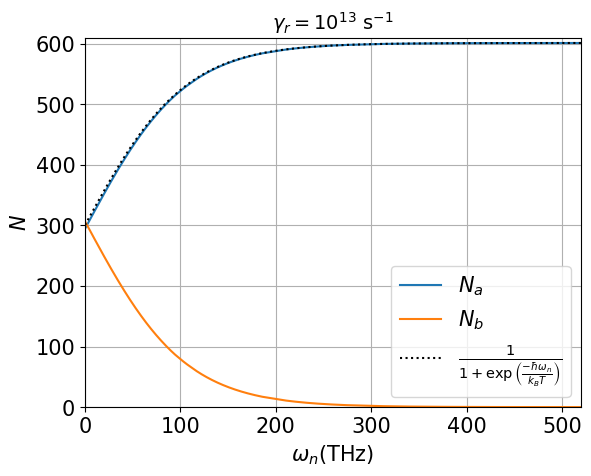

In [62]:
plt.xlim(0,520)
plt.ylim(0,610)
plt.title(r"$\gamma_r=10^{13}$ s$^{-1}$", fontsize=14)
plt.xlabel(r"$\omega_n$(THz)")
plt.ylabel(r"$N$")
plt.plot(omega_n, N-Nb, label = "$N_a$" )
plt.plot(omega_n, Nb, label = "$N_b$")
plt.plot(omega_n, N*fan, linestyle = ':', color='k', label = r"$\frac{1}{1+\exp\left(\frac{-\hbar\omega_n}{k_B T}\right)}$")
plt.legend(loc = 'lower right')
plt.grid()
#plt.savefig("./Graphs/Nab_active_tp001.png", dpi=300)
plt.show()

# Figure 10

In [63]:
N_O = np.load('./Data/Nk_tp1_multi_A_N_passive.npz')
Omega_k = N_O['Omega_k']
Nk_l = N_O['Nk_l']

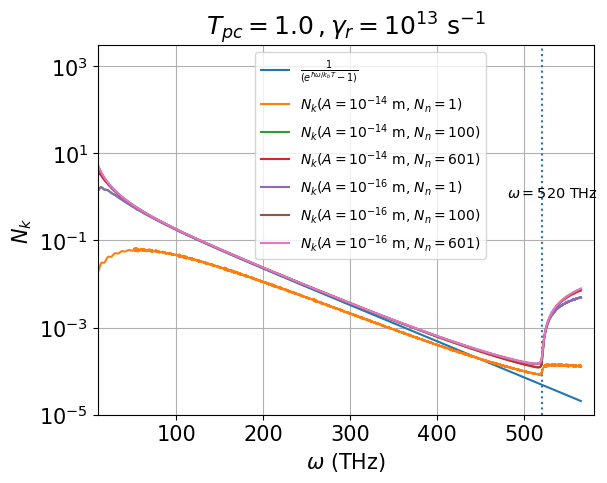

In [64]:
plt.xlim(10,580)
plt.ylim(1e-5,3000)
plt.axvline(520,ls=':')
#plt.ylim(1e-4,10)
#plt.ylim(1e-5,400)
#plt.ylim(1e-3,10)
plt.title(r'$T_{pc}=1.0\,,\gamma_r=10^{13}$ s$^{-1}$')
plt.yscale('log')
plt.ylabel(r'$N_k$')
plt.xlabel(r'$\omega$ (THz)') 
plt.text(480,1,r'$\omega=520$ THz',size='x-small')
plt.plot(Omega_k, 1/(np.exp(hbar_normal*Omega_k/(kb_normal*Temp))-1), label=r'$\frac{1}{(e^{\hbar\omega/k_b T} -1)}$')
plt.plot(Omega_k,Nk_l[0], label=r'$N_k(A=10^{-14}$ m, $N_n=1)$')
plt.plot(Omega_k,Nk_l[1], label=r'$N_k(A=10^{-14}$ m, $N_n=100)$')
plt.plot(Omega_k,Nk_l[2], label=r'$N_k(A=10^{-14}$ m, $N_n=601)$')
plt.plot(Omega_k,Nk_l[3], label=r'$N_k(A=10^{-16}$ m, $N_n=1)$')
plt.plot(Omega_k,Nk_l[4], label=r'$N_k(A=10^{-16}$ m, $N_n=100)$')
plt.plot(Omega_k,Nk_l[5], label=r'$N_k(A=10^{-16}$ m, $N_n=601)$')
plt.legend(loc=9, bbox_to_anchor=(0.55, 1), prop={'size': 10})
plt.grid()
#plt.savefig("./Graphs/Nk_tp1_multi_A_N_passive.png",dpi=300)
plt.show()

# Figure 11

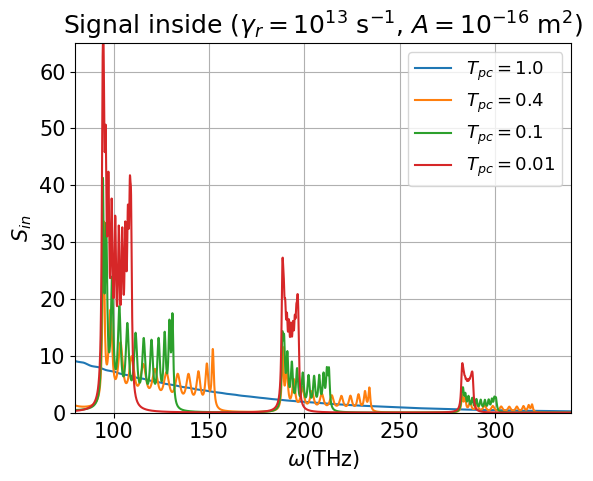

In [75]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp1.0_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/recursive/Photon_n_0_6pi_rec_Tp1.0_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.4_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.1_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.01_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz']
labels = [r"$T_{pc} = 1.0$", r"$T_{pc}= 0.4$", r"$T_{pc} = 0.1$", r"$T_{pc} = 0.01$"]
xlim = [80,340]
ylim = [0,65]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal inside ($\gamma_r=10^{13}$ s$^{-1}$, $A=10^{-16}$ m$^2$)', './Graphs/S_in_n1000_multi_tp_gr1e13_gc1e9_A1e-16_N601.png', xlim, ylim)

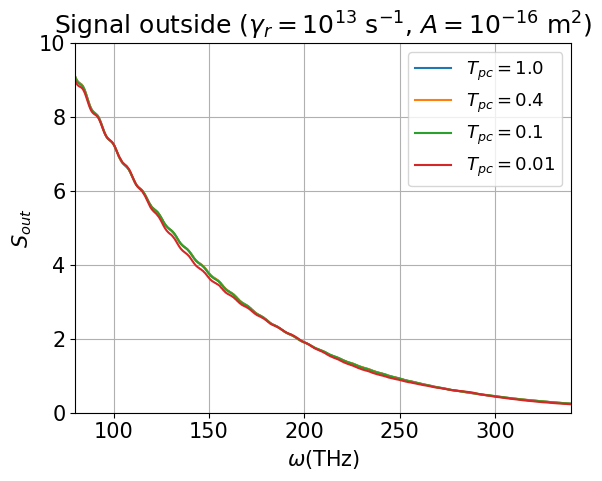

In [76]:
xlim = [80,340]
ylim = [0,10]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'Out', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal outside ($\gamma_r=10^{13}$ s$^{-1}$, $A=10^{-16}$ m$^2$)', './Graphs/S_out_n1000_multi_tp_gr1e13_gc1e9_A1e-16_N601.png', xlim, ylim)

# Figure 12

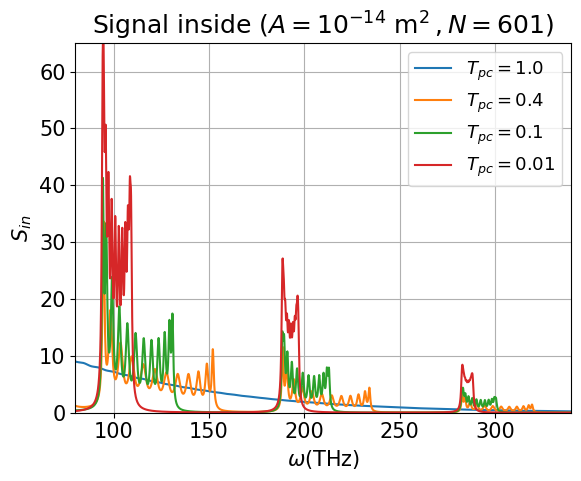

In [78]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp1.0_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/recursive/Photon_n_0_6pi_rec_Tp1.0_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.4_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.1_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N601.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.01_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N601.npz']
labels = [r"$T_{pc} = 1.0$", r"$T_{pc} = 0.4$", r"$T_{pc} = 0.1$", r"$T_{pc} = 0.01$"]
xlim = [80,340]
ylim = [0,65]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal inside ($A=10^{-14}$ m$^2\,, N=601$)', './Graphs/S_in_n1000_multi_tp_gr1e13_gc1e9_A1e-14_N601.png', xlim, ylim)

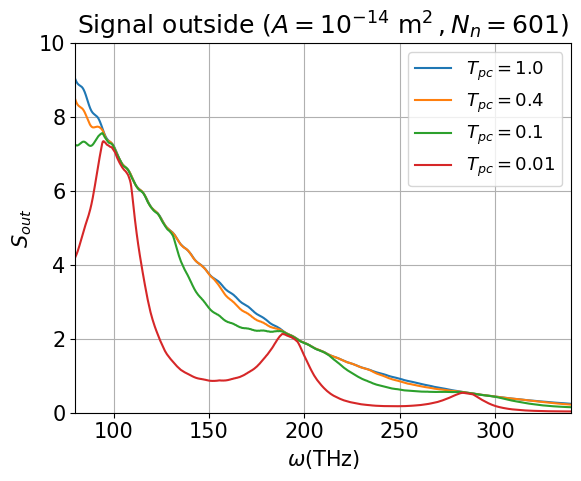

In [79]:
xlim = [80,340]
ylim = [0,10]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'Out', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal outside ($A=10^{-14}$ m$^2\,, N_n=601$)', './Graphs/S_out_n1000_multi_tp_gr1e13_gc1e9_A1e-14_N601.png', xlim, ylim)

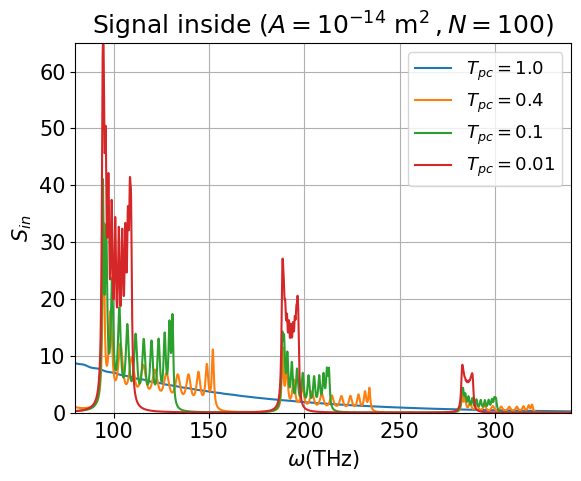

In [80]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data//Emodes/Emodes_0_6pi_Tp1.0_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/recursive/Photon_n_0_6pi_rec_Tp1.0_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N100.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.4_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N100.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.1_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N100.npz',
            './Data/recursive/Photon_n_0_6pi_rec_Tp0.01_n1000_L1200_gr1e+13_gc1e+09_A1e-14_N100.npz']
labels = [r"$T_{pc} = 1.0$", r"$T_{pc} = 0.4$", r"$T_{pc} = 0.1$", r"$T_{pc} = 0.01$"]
xlim = [80,340]
ylim = [0,65]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal inside ($A=10^{-14}$ m$^2\,, N=100$)', './Graphs/S_in_n1000_multi_tp_gr1e13_gc1e9_A1e-14_N100.png', xlim, ylim)

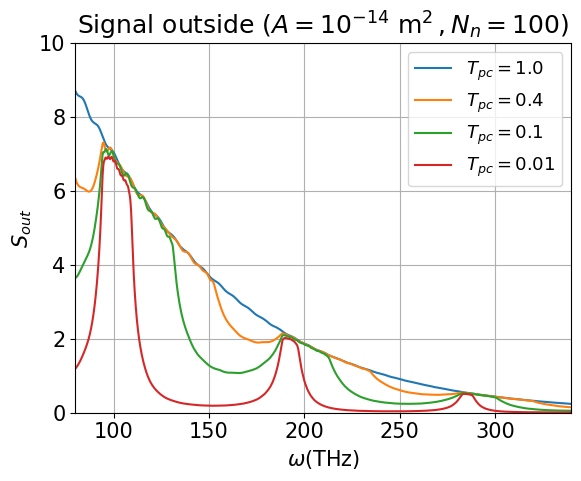

In [81]:
xlim = [80,340]
ylim = [0,10]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'Out', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal outside ($A=10^{-14}$ m$^2\,, N_n=100$)', './Graphs/S_out_n1000_multi_tp_gr1e13_gc1e9_A1e-14_N100.png', xlim, ylim)

# Figure 13

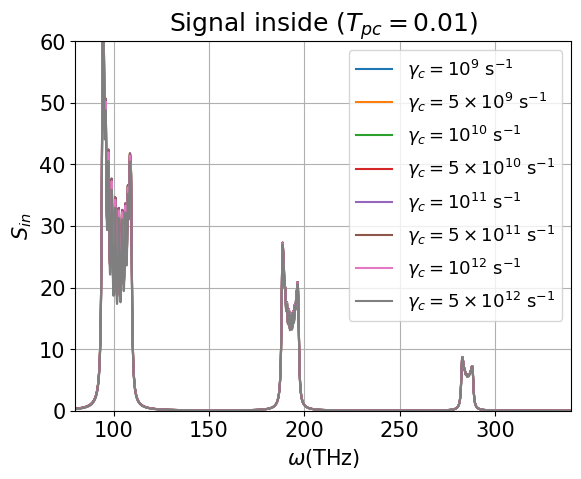

In [85]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']*8
PN_files = ['./Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc1e+09.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc5e+09.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc1e+10.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc5e+10.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc1e+11.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc5e+11.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc1e+12.npz',
            './Data/recursive/Photon_n_0_6pi_Tp0.01_n1000_gr1e+13_gc5e+12.npz']
labels = [r"$\gamma_c=10^9$ s$^{-1}$", r"$\gamma_c=5\times 10^9$ s$^{-1}$", r"$\gamma_c=10^{10}$ s$^{-1}$", 
          r"$\gamma_c=5\times 10^{10}$ s$^{-1}$", r"$\gamma_c=10^{11}$ s$^{-1}$", r"$\gamma_c=5\times 10^{11}$ s$^{-1}$",
          r"$\gamma_c=10^{12}$ s$^{-1}$", r"$\gamma_c=5\times 10^{12}$ s$^{-1}$"]
xlim = [80,340]
ylim = [0,60]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal inside ($T_{pc}=0.01$)', './Graphs/S_in_n1000_L1200_gr1e13_multi_gc_tp001.png', xlim, ylim)

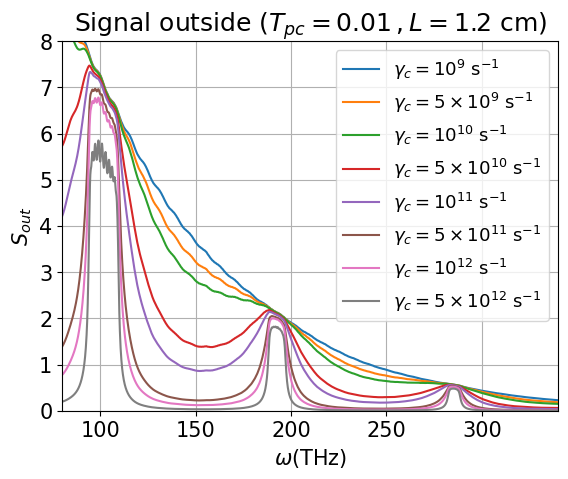

In [86]:
xlim = [80,340]
ylim = [0,8]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal outside ($T_{pc}=0.01\,, L=1.2$ cm)', './Graphs/S_out_n1000_L1200_gr1e13_multi_gc_tp001.png', xlim, ylim)

# Figure 14 & 15

In [137]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
Ndata_files = "./Data/rk45/passive/Photon_n_Tp0.01_n500_gr1.0e+13_t00.0_tb400.0_v2.npz"

In [138]:
emodes = np.load(emodes_files)
Ndata = np.load(Ndata_files, allow_pickle=True)

In [139]:
p_np = Ndata['parameters']
parameters = p_np.tolist()

In [140]:
gamma = parameters['gamma']
gamma_normal = parameters['gamma_normal']
gamma_c = parameters['gamma_c']
gamma_r = parameters['gamma_r']
Lambda_0 = parameters['Lambda_0']
omega_0 = parameters['omega_0']
N = parameters['N']
Np = parameters['Np']
Temp_p = parameters['Temp_p']
Temp = parameters['Temp']
A = parameters['A']
D = parameters['D']

In [141]:
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma
tl = Ndata['t']
Nkt = Ndata['Nkt']
Nbt = Ndata['Nbt']
nn = 500
omega_n = np.linspace(0.1,5.2e14,nn)/gamma

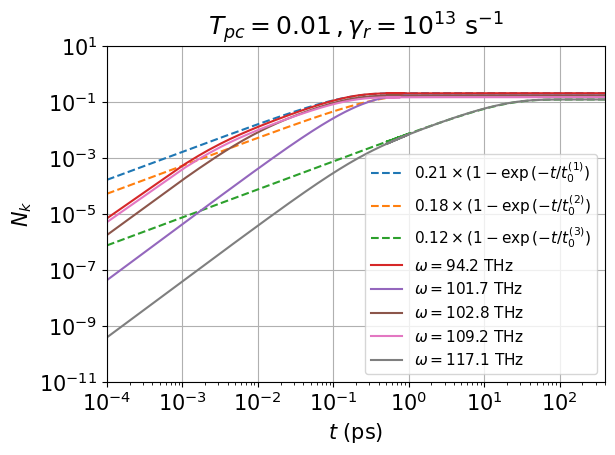

In [142]:
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,400)
plt.ylim(1e-11,10)
plt.ylabel(r"$N_k$")
plt.xlabel(r"$t$ (ps)") 
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{13}$ s$^{-1}$")
#plt.plot(tl, 750*(1-np.exp(-tl/1100)),label=r'$750\times (1-\exp{(-t/1100)})$')
a1=0.20521412
a2=0.12336719
b1=0.17769037
b2=0.33586905
c1=0.12240338
c2=16.13449833

a_1=610
a_2=4.5
a_3=143
a_4=0.04
plt.plot(tl, a1*(1-np.exp(-tl/a2)), label=r'$0.21\times(1-\exp{(-t/t_0^{(1)}})$',ls='--')
plt.plot(tl, b1*(1-np.exp(-tl/b2)), label=r'$0.18\times(1-\exp{(-t/t_0^{(2)}})$',ls='--')
plt.plot(tl, c1*(1-np.exp(-tl/c2)), label=r'$0.12\times(1-\exp{(-t/t_0^{(3)}})$',ls='--')
#plt.plot(tl, a_1*tl**2, label=r'$a_1\times t^2$',ls='-.')
#plt.plot(tl, a_2*tl**2, label=r'$a_2\times t^2$',ls='-.')
#plt.plot(tl, a_3*tl**2, label=r'$a_3\times t^2$',ls='-.')
#plt.plot(tl, a_4*tl**2, label=r'$a_4\times t^2$',ls='-.')
plt.plot(tl, Nkt[:,1200],label=r'$\omega=94.2$ THz')
plt.plot(tl, Nkt[:,1300],label=r'$\omega=101.7$ THz')
plt.plot(tl, Nkt[:,1314],label=r'$\omega=102.8$ THz')
plt.plot(tl, Nkt[:,1400],label=r'$\omega=109.2$ THz')
plt.plot(tl, Nkt[:,1500],label=r'$\omega=117.1$ THz')
plt.legend(loc=4,prop={'size': 11})
plt.tight_layout()
plt.grid()
plt.savefig("./Graphs/Nkt_time_tp001_passive.png",dpi=300)
plt.show()

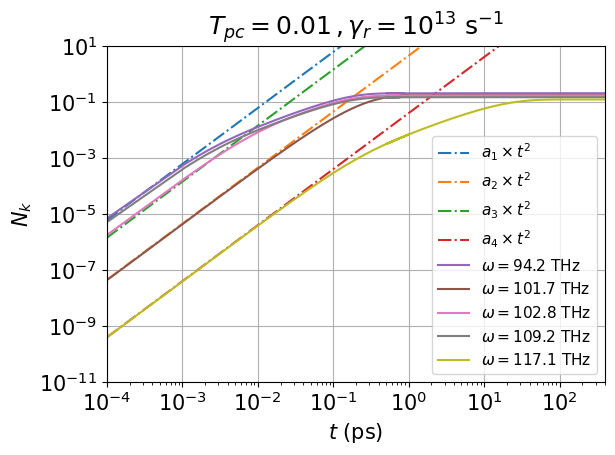

In [145]:
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,400)
plt.ylim(1e-11,10)
plt.ylabel(r"$N_k$")
plt.xlabel(r"$t$ (ps)") 
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{13}$ s$^{-1}$")
#plt.plot(tl, 750*(1-np.exp(-tl/1100)),label=r'$750\times (1-\exp{(-t/1100)})$')
a1=0.20521412
a2=0.12336719
b1=0.17769037
b2=0.33586905
c1=0.12240338
c2=16.13449833

a_1=610
a_2=4.5
a_3=143
a_4=0.04
#plt.plot(tl, a1*(1-np.exp(-tl/a2)), label=r'$0.21\times(1-\exp{(-t/t_0^{(1)}})$',ls='--')
#plt.plot(tl, b1*(1-np.exp(-tl/b2)), label=r'$0.18\times(1-\exp{(-t/t_0^{(2)}})$',ls='--')
#plt.plot(tl, c1*(1-np.exp(-tl/c2)), label=r'$0.12\times(1-\exp{(-t/t_0^{(3)}})$',ls='--')
plt.plot(tl, a_1*tl**2, label=r'$a_1\times t^2$',ls='-.')
plt.plot(tl, a_2*tl**2, label=r'$a_2\times t^2$',ls='-.')
plt.plot(tl, a_3*tl**2, label=r'$a_3\times t^2$',ls='-.')
plt.plot(tl, a_4*tl**2, label=r'$a_4\times t^2$',ls='-.')
plt.plot(tl, Nkt[:,1200],label=r'$\omega=94.2$ THz')
plt.plot(tl, Nkt[:,1300],label=r'$\omega=101.7$ THz')
plt.plot(tl, Nkt[:,1314],label=r'$\omega=102.8$ THz')
plt.plot(tl, Nkt[:,1400],label=r'$\omega=109.2$ THz')
plt.plot(tl, Nkt[:,1500],label=r'$\omega=117.1$ THz')
plt.legend(prop={'size': 11})
plt.tight_layout()
plt.grid()
plt.savefig("./Graphs/Nkt_time_tp001_passive_2.png",dpi=300)
plt.show()

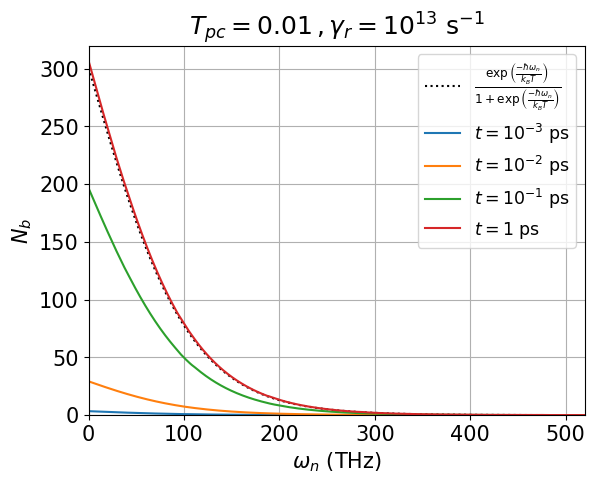

In [143]:
#plt.yscale('log')
plt.xlim(0,520)
plt.ylim(0,320)
fbn = fb(omega_n,Temp)
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{13}$ s$^{-1}$")
plt.xlabel(r'$\omega_n$ (THz)')
plt.ylabel(r'$N_b$')
plt.plot(omega_n, N*fbn, linestyle = ':', color='k', label = r"$\frac{\exp\left(\frac{-\hbar\omega_n}{k_B T}\right)}{1+\exp\left(\frac{-\hbar\omega_n}{k_B T}\right)}$")
plt.plot(omega_n,Nbt[1,:],label=r'$t=10^{-3}$ ps')
plt.plot(omega_n,Nbt[18,:],label=r'$t=10^{-2}$ ps')
plt.plot(omega_n,Nbt[196,:],label=r'$t=10^{-1}$ ps')
plt.plot(omega_n,Nbt[1970,:],label=r'$t=1$ ps')
plt.legend(fontsize='small')
plt.grid()
#plt.savefig('./Graphs/Nbt_tp001_passive_multi_t.png',dpi=300)
plt.show()

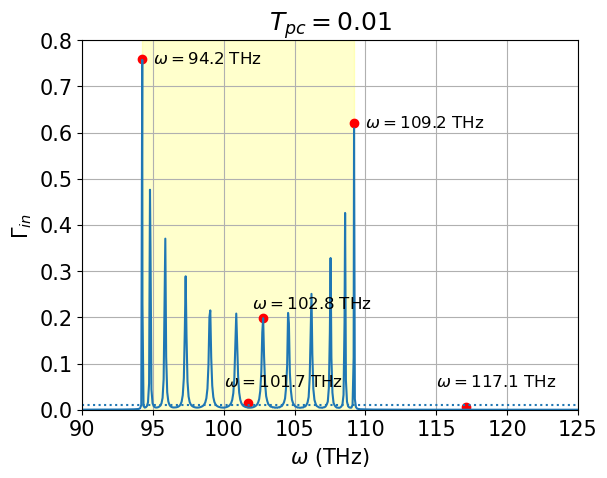

In [144]:
plt.xlim(90, 125)
plt.ylim(0,0.8)
plt.title(r"$T_{pc}=0.01$")

plt.axvspan(94.25,109.2,color='yellow',alpha=0.2)

plt.plot(94.2,0.76,'ro') 
plt.plot(109.2,0.62,'ro') 
plt.plot(101.7,0.015,'ro') 
plt.plot(117.1,0.005,'ro')
plt.plot(102.78,0.198,'ro')

plt.text(95,0.75,r'$\omega=94.2$ THz', fontsize=12)
plt.text(110,0.61,r'$\omega=109.2$ THz', fontsize=12)
plt.text(100,0.05,r'$\omega=101.7$ THz', fontsize=12)
plt.text(102,0.22,r'$\omega=102.8$ THz', fontsize=12)
plt.text(115,0.05,r'$\omega=117.1$ THz', fontsize=12)

plt.ylabel(r"$\Gamma_{in}$")
plt.xlabel(r"$\omega$ (THz)")
plt.axhline(0.01,ls=':')
plt.plot(Omega_k, G_in)
plt.grid()
#plt.savefig("./Graphs/G_in_tp001_Nkt_modes_indicate.png",dpi=300)
plt.show()

# Figure 16

In [8]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
Ndata_files = "./Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc1.0e+09.npz"

In [9]:
emodes = np.load(emodes_files)
Ndata = np.load(Ndata_files, allow_pickle=True)

In [10]:
Nb = Ndata['Nb']
Nk = Ndata['Nk']
p_np = Ndata['parameters']
parameters = p_np.tolist()

In [11]:
parameters

{'gamma': 1000000000000.0,
 'gamma_normal': 1,
 'gamma_c': 0.001,
 'gamma_r': 0.01,
 'Lambda_0': 0.01,
 'omega_0': 160.0,
 'N': 601,
 'Np': 12,
 'Temp_p': 400,
 'Temp': 400,
 'A': 1e-16,
 'D': 0.00774339381694}

In [17]:
N = parameters['N']
Temp = parameters['Temp']
nn = 500
omega_n = np.linspace(0.1,5.2e14,nn)/gamma
fan = fa(omega_n,Temp)

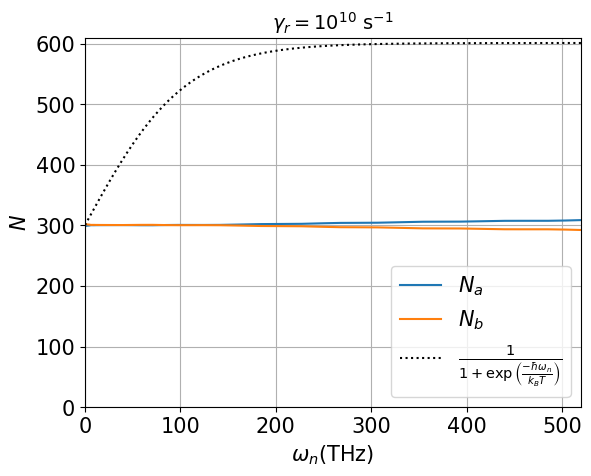

In [18]:
plt.xlim(0,520)
plt.ylim(0,610)
plt.title(r"$\gamma_r=10^{10}$ s$^{-1}$", fontsize=14)
plt.xlabel(r"$\omega_n$(THz)")
plt.ylabel(r"$N$")
plt.plot(omega_n, N-Nb, label = "$N_a$" )
plt.plot(omega_n, Nb, label = "$N_b$")
plt.plot(omega_n, N*fan, linestyle = ':', color='k', label = r"$\frac{1}{1+\exp\left(\frac{-\hbar\omega_n}{k_B T}\right)}$")
plt.legend(loc = 'lower right')
plt.grid()
#plt.savefig("./Graphs/Nab_active_tp001.png", dpi=300)
plt.show()

# Figure 17

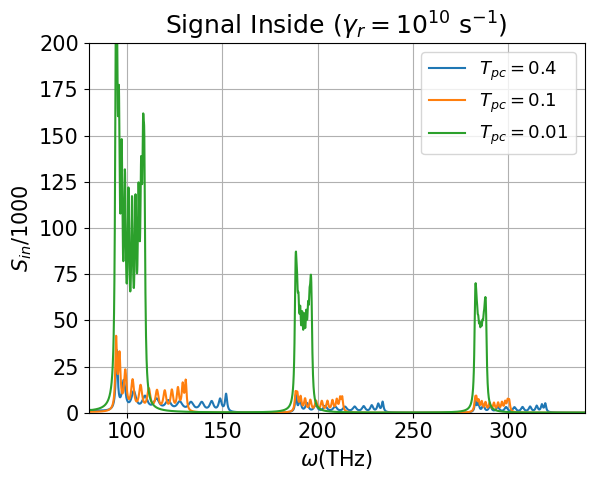

In [21]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/krylov/Photon_n_0_6pi_kry_Tp0.40_n500_gr1.0e+10_gc1.0e+09.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.10_n500_gr1.0e+10_gc1.0e+09.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc1.0e+09.npz']
labels = [r'$T_{pc}=0.4$',r'$T_{pc}=0.1$',r'$T_{pc}=0.01$']
xlim = [80,340]
ylim = [0,200]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal Inside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_in_n500_gr1e10_gc1e9_A1e-16_N601.png', 
             xlim=xlim, ylim=ylim, yscale=True)

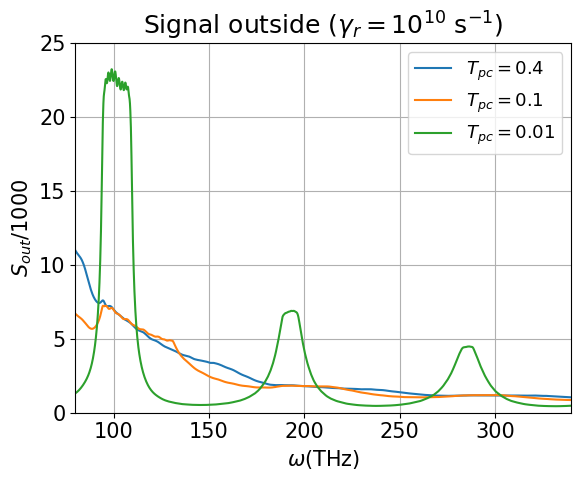

In [22]:
xlim = [80,340]
ylim = [0,25]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal outside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_out_n500_gr1e10_gc1e9_A1e-16_N601.png', 
             xlim=xlim, ylim=ylim, yscale=True)

# Figure 18

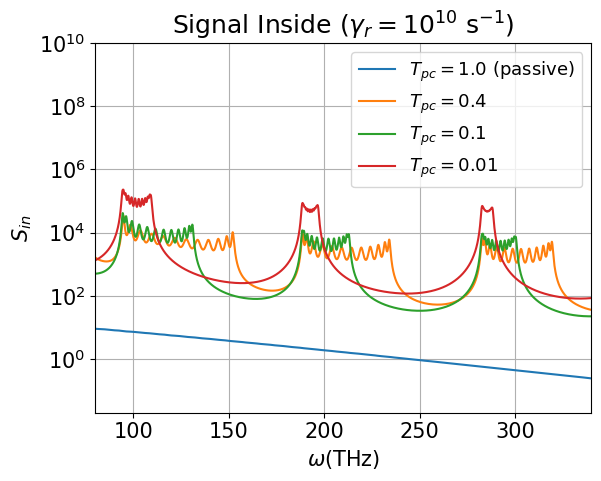

In [25]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp1.0_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.4_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.1_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/recursive/Photon_n_0_6pi_rec_Tp1.0_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.40_n500_gr1.0e+10_gc1.0e+09.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.10_n500_gr1.0e+10_gc1.0e+09.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc1.0e+09.npz']
labels = [r'$T_{pc}=1.0$ (passive)',r'$T_{pc}=0.4$',r'$T_{pc}=0.1$',r'$T_{pc}=0.01$']
xlim=[80,340]
ylim=[0.02,1e10]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal Inside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_in_n500_gr1e10_gc1e9_compare.png', 
             xlim=xlim, ylim=ylim, yscale=False, logyscale=True)

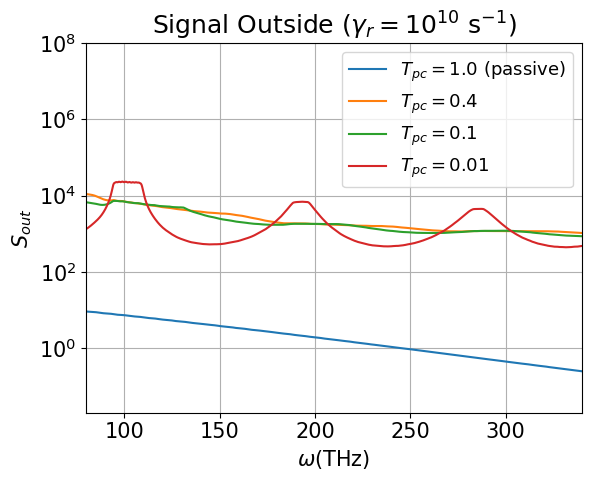

In [26]:
xlim=[80,340]
ylim=[0.02,1e8]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal Outside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_out_n500_gr1e10_gc1e9_compare.png', 
             xlim = xlim, ylim=ylim, yscale=False, logyscale=True)

# Figure 19

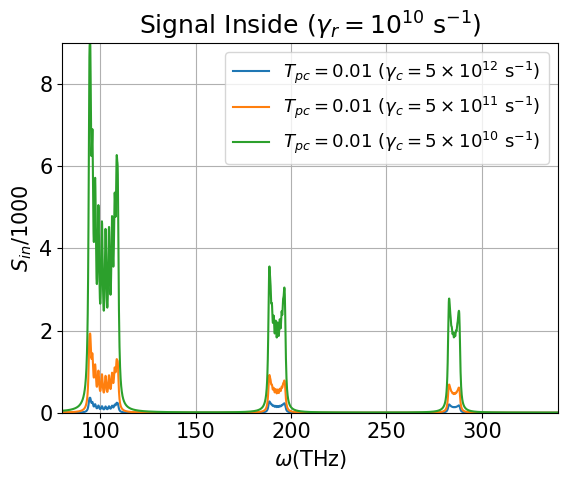

In [27]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']*3
PN_files = ['./Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+12.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+11.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+10.npz',]
labels = [r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{12}$ s$^{-1}$) ', r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{11}$ s$^{-1}$)', r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{10}$ s$^{-1}$)']
xlim=[80,340]
ylim=[0,9]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal Inside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_in_n500_tp001_gr1e10_multi_gc.png', 
             xlim=xlim, ylim=ylim, yscale=True, logyscale=False)

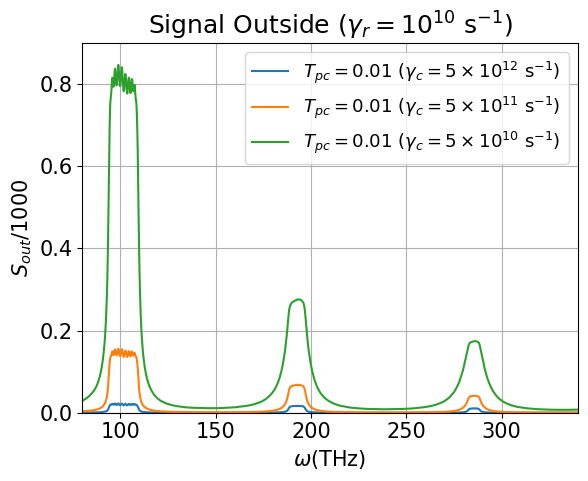

In [28]:
xlim=[80,340]
ylim=[0,0.9]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal Outside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_out_n500_tp001_gr1e10_multi_gc.png', 
             xlim = xlim, ylim=ylim, yscale=True, logyscale=False)

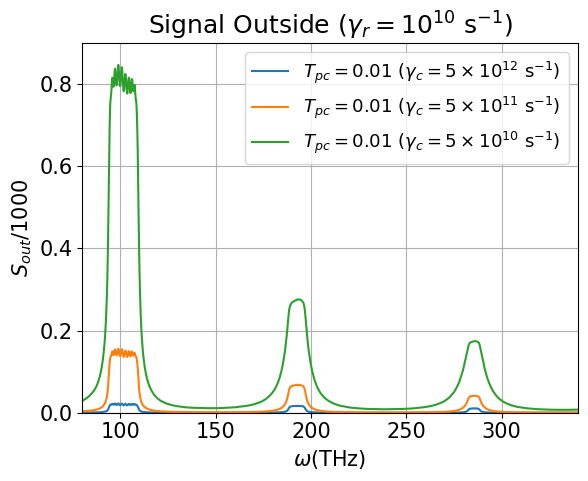

In [77]:
xlim=[80,340]
ylim=[0,0.9]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal Outside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_out_n500_tp001_gr1e10_multi_gc.png', 
             xlim = xlim, ylim=ylim, yscale=True, logyscale=False)

# Figure 20

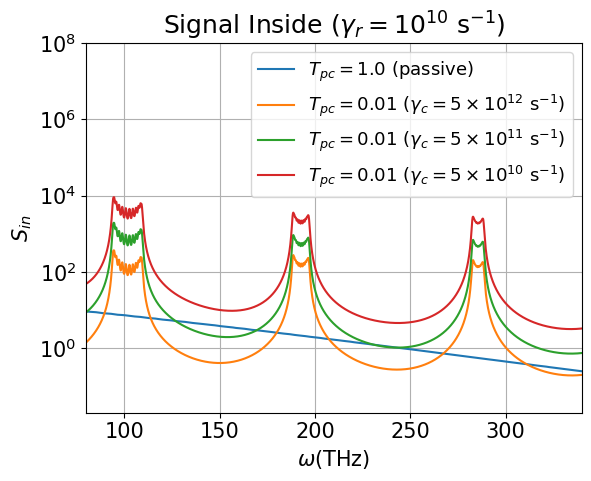

In [29]:
omega_l = np.linspace(1e13,5e14,5000)/gamma
emodes_files = ['./Data/Emodes/Emodes_0_6pi_Tp1.0_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz',
                './Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz']
PN_files = ['./Data/recursive/Photon_n_0_6pi_rec_Tp1.0_n1000_L1200_gr1e+13_gc1e+09_A1e-16_N601.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+12.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+11.npz',
            './Data/krylov/Photon_n_0_6pi_kry_Tp0.01_n500_gr1.0e+10_gc5.0e+10.npz']
labels = [r'$T_{pc}=1.0$ (passive)', r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{12}$ s$^{-1}$)', r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{11}$ s$^{-1}$)'
          , r'$T_{pc}=0.01$ ($\gamma_c=5\times 10^{10}$ s$^{-1}$)']
xlim=[80,340]
ylim=[0.02,1e8]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'IN', r'$\omega$(THz)', r'$S_{in}$',
             r'Signal Inside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_in_n500_gr1e10_multi_gc_log.png', 
             xlim=xlim, ylim=ylim, yscale=False, logyscale=True)

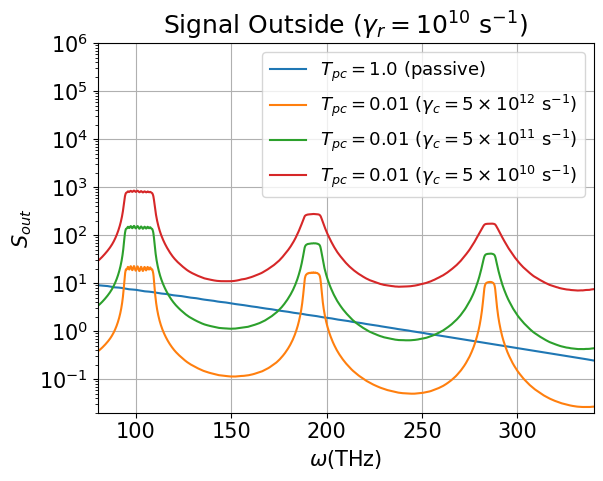

In [30]:
xlim=[80,340]
ylim=[0.02,1e6]
plot_s_omega(omega_l, emodes_files, PN_files, labels, 'OUT', r'$\omega$(THz)', r'$S_{out}$',
             r'Signal Outside ($\gamma_r = 10^{10}$ s$^{-1}$)', './Graphs/S_out_n500_gr1e10_multi_gc_log.png', 
             xlim = xlim, ylim=ylim, yscale=False, logyscale=True)

# Figure 21 - 23

In [32]:
filename='./Data/rk45/active/Photon_n_Tp0.01_n500_gr1.0e+10_gc1.0e+09_t00.0_tb2027.8_v2.npz'
Nkdata=np.load(filename,allow_pickle=True)
Nat = Nkdata['Nat']
Nbt = Nkdata['Nbt']
Nkt = Nkdata['Nkt']
tl = Nkdata['t']
parameters = Nkdata['parameters']
parameters

array({'gamma': 1000000000000.0, 'gamma_normal': 1, 'gamma_c': 0.001, 'gamma_r': 0.01, 'Lambda_0': 0.01, 'omega_0': 160.0, 'N': 601, 'Np': 12, 'Temp_p': 400, 'Temp': 400, 'A': 1e-16, 'D': 0.00774339381694},
      dtype=object)

In [34]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

In [35]:
print(Omega_k[1200])
print(Omega_k[1300])
print(Omega_k[1400])
print(Omega_k[1500])

94.25040937704107531
101.71783628206606939
109.196185668677594086
117.09765795786541392


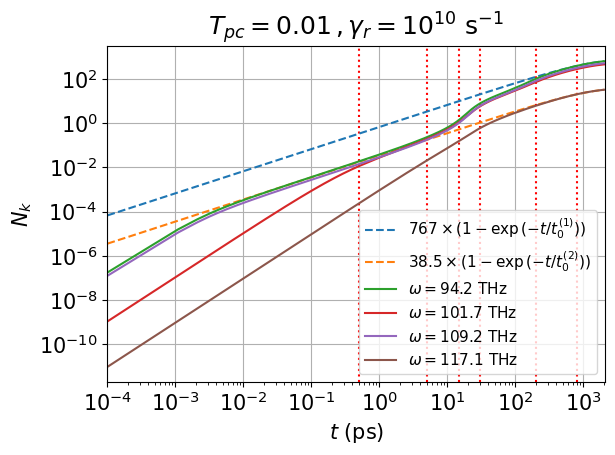

In [36]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$N_k$")
plt.xlabel(r"$t$ (ps)") 
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{10}$ s$^{-1}$")
plt.axvline(0.5,ls=":",color='r')
plt.axvline(5.1,ls=":",color='r')
plt.axvline(14.8,ls=":",color='r')
plt.axvline(30,ls=":",color='r')
plt.axvline(200,ls=":",color='r')
plt.axvline(800,ls=":",color='r')
#plt.ylim(0.01,1e4)
plt.xlim(1e-4,2100)
plt.plot(tl, 767*(1-np.exp(-tl/1136)),label=r'$767\times (1-\exp{(-t/t_0^{(1)})})$',ls='--')
plt.plot(tl, 38.53*(1-np.exp(-tl/1080.75)),label=r'$38.5\times (1-\exp{(-t/t_0^{(2)})})$',ls='--')
#plt.plot(tl,p_1200(tl),label=r'$a_3 t^3 + a_2 t^2 + a_1 t + a_0$',ls='-.',color='r')
plt.plot(tl,Nkt[:,1200],label=r'$\omega=94.2$ THz')
plt.plot(tl,Nkt[:,1300],label=r'$\omega=101.7$ THz')
plt.plot(tl,Nkt[:,1400],label=r'$\omega=109.2$ THz')
plt.plot(tl,Nkt[:,1500],label=r'$\omega=117.1$ THz')
plt.legend(prop={'size': 11})
plt.tight_layout()
plt.grid()
#plt.savefig("./Graphs/Nkt_time_tp001_active.png",dpi=300)
plt.show()

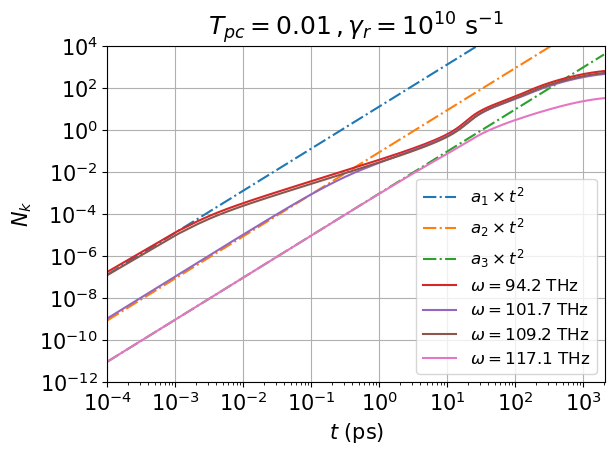

In [37]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$N_k$")
plt.xlabel(r"$t$ (ps)") 
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{10}$ s$^{-1}$")
plt.xlim(1e-4,2100)
plt.ylim(1e-12,1e4)

a3=9.46597745e-04
a2=0.08730626
a1=13

#plt.plot(tl, 767*(1-np.exp(-tl/1136)),label=r'$767\times (1-\exp{(-t/t_0^{(1)})})$',ls='--')
#plt.plot(tl, 38.53*(1-np.exp(-tl/1080.75)),label=r'$38.5\times (1-\exp{(-t/t_0^{(2)})})$',ls='--')
plt.plot(tl,a1*tl**2,label=r'$a_1\times t^2$',ls='-.')
plt.plot(tl,a2*tl**2,label=r'$a_2\times t^2$',ls='-.')
plt.plot(tl,a3*tl**2,label=r'$a_3\times t^2$',ls='-.')
plt.plot(tl,Nkt[:,1200],label=r'$\omega=94.2$ THz')
plt.plot(tl,Nkt[:,1300],label=r'$\omega=101.7$ THz')
plt.plot(tl,Nkt[:,1400],label=r'$\omega=109.2$ THz')
plt.plot(tl,Nkt[:,1500],label=r'$\omega=117.1$ THz')
plt.legend(prop={'size': 12})
plt.grid()
plt.tight_layout()
#plt.savefig("./Graphs/Nkt_time_tp001_active_2.png",dpi=300)
plt.show()

In [38]:
def loc_val(array,values):
    for value in values:
        ind = np.abs(array-value).argmin()
        print(f"value={value:.2e}: index={ind}, true_value={array[ind]:.2e}")
loc_val(tl, [1e-3,0.7,5,15,30,200,800])

value=1.00e-03: index=1, true_value=1.10e-03
value=7.00e-01: index=986, true_value=5.08e-01
value=5.00e+00: index=995, true_value=5.08e+00
value=1.50e+01: index=1014, true_value=1.48e+01
value=3.00e+01: index=1043, true_value=3.00e+01
value=2.00e+02: index=1208, true_value=2.00e+02
value=8.00e+02: index=2330, true_value=8.00e+02


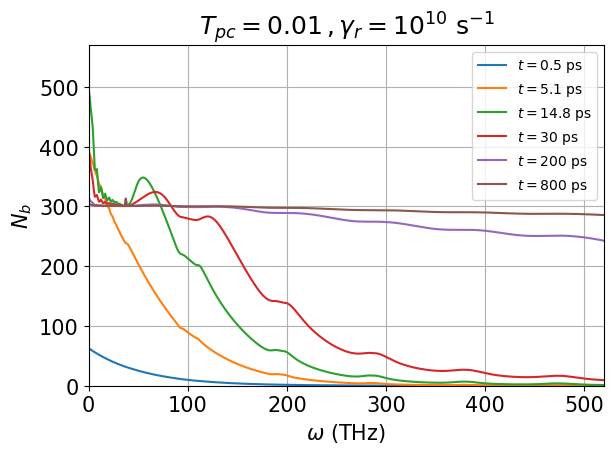

In [41]:
#plt.yscale('log')
plt.ylim(0,570)
plt.xlim(0,520)
plt.title(r"$T_{pc}=0.01\,, \gamma_r=10^{10}$ s$^{-1}$")
plt.xlabel(r'$\omega$ (THz)')
plt.ylabel(r'$N_b$')
#plt.plot(omega_n,Nbt[1,:], label=r'$t=5.59$ ps')
plt.plot(omega_n,Nbt[986,:], label=r'$t=0.5$ ps')
plt.plot(omega_n,Nbt[995,:], label=r'$t=5.1$ ps')
plt.plot(omega_n,Nbt[1014,:], label=r'$t=14.8$ ps')
plt.plot(omega_n,Nbt[1043,:], label=r'$t=30$ ps')
plt.plot(omega_n,Nbt[1208,:], label=r'$t=200$ ps')
plt.plot(omega_n,Nbt[2330,:], label=r'$t=800$ ps')
plt.legend(prop={'size': 10})
plt.grid()
plt.tight_layout()
#plt.savefig('./Graphs/Nbt_tp001_active.png',dpi=300)
plt.show()

# Figure 24 & 25

In [42]:
filename='./Data/rk45/active/Photon_n_Tp0.01_n500_gr1.0e+10_gc2.5e+10_t00.0_tb2500.0.npz'
Nkdata=np.load(filename,allow_pickle=True)
Nat = Nkdata['Nat']
Nbt = Nkdata['Nbt']
Nkt = Nkdata['Nkt']
tl = Nkdata['t']
parameters = Nkdata['parameters']
parameters

array({'gamma': 1000000000000.0, 'gamma_normal': 1, 'gamma_c': 0.025, 'gamma_r': 0.01, 'Lambda_0': 0.01, 'omega_0': 160.0, 'N': 601, 'Np': 12, 'Temp_p': 400, 'Temp': 400, 'A': 1e-16, 'D': 0.00774339381694},
      dtype=object)

In [43]:
emodes_files = "./Data/Emodes/Emodes_0_6pi_Tp0.01_L1200_Np12.npz"
emodes = np.load(emodes_files)
ks = emodes["ks"]
G_in = emodes["G_in"]
G_out = emodes["G_out"]
G_out_ep = emodes["G_out_ep"]
Omega_k = ks/lp*c0/gamma

In [44]:
print(Omega_k[1200])
print(Omega_k[1300])
print(Omega_k[1400])
print(Omega_k[1500])

94.25040937704107531
101.71783628206606939
109.196185668677594086
117.09765795786541392


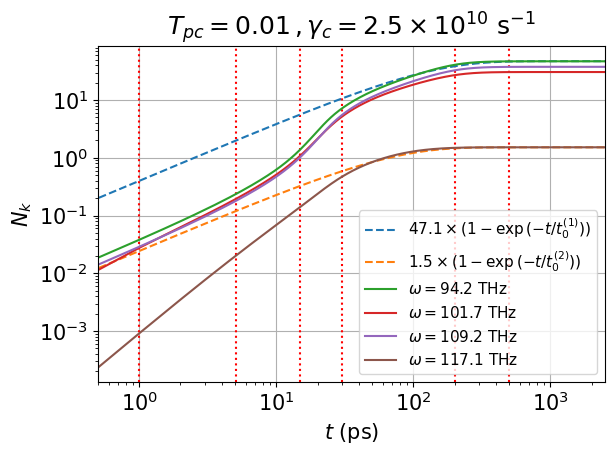

In [48]:
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$N_k$")
plt.xlabel(r"$t$ (ps)") 
plt.title(r"$T_{pc}=0.01\,, \gamma_c=2.5\times 10^{10}$ s$^{-1}$")
plt.axvline(1,ls=":",color='r')
plt.axvline(5.1,ls=":",color='r')
plt.axvline(14.8,ls=":",color='r')
plt.axvline(30,ls=":",color='r')
plt.axvline(200,ls=":",color='r')
plt.axvline(500,ls=":",color='r')
#plt.ylim(0.01,1e4)
plt.xlim(0.5,2500)
plt.plot(tl, 47.13*(1-np.exp(-tl/117.647)),label=r'$47.1\times (1-\exp{(-t/t_0^{(1)})})$',ls='--')
plt.plot(tl, 1.52*(1-np.exp(-tl/61.874)),label=r'$1.5\times (1-\exp{(-t/t_0^{(2)})})$',ls='--')
plt.plot(tl,Nkt[:,1200],label=r'$\omega=94.2$ THz')
plt.plot(tl,Nkt[:,1300],label=r'$\omega=101.7$ THz')
plt.plot(tl,Nkt[:,1400],label=r'$\omega=109.2$ THz')
plt.plot(tl,Nkt[:,1500],label=r'$\omega=117.1$ THz')
plt.legend(prop={'size': 11})
plt.tight_layout()
plt.grid()
#plt.savefig("./Graphs/Nkt_time_tp001_active_gc_2.5e10.png",dpi=300)
plt.show()

In [46]:
def loc_val(array,values):
    for value in values:
        ind = np.abs(array-value).argmin()
        print(f"value={value:.2e}: index={ind}, true_value={array[ind]:.2e}")
loc_val(tl,[1,5,15,30,200,500])

value=1.00e+00: index=1, true_value=1.01e+00
value=5.00e+00: index=9, true_value=5.08e+00
value=1.50e+01: index=28, true_value=1.48e+01
value=3.00e+01: index=57, true_value=2.99e+01
value=2.00e+02: index=247, true_value=1.99e+02
value=5.00e+02: index=416, true_value=5.00e+02


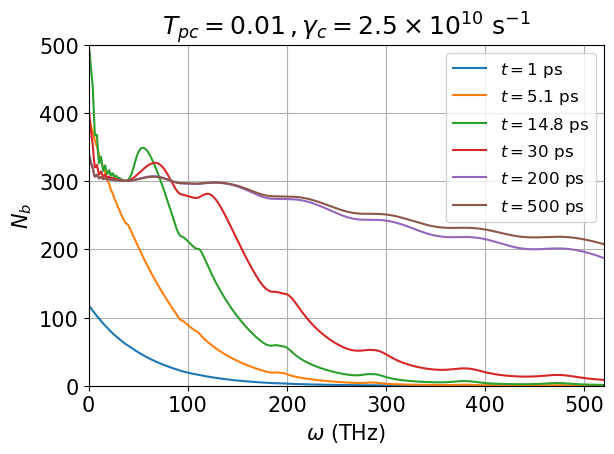

In [49]:
#plt.yscale('log')
plt.ylim(0,500)
plt.xlim(0,520)
plt.title(r"$T_{pc}=0.01\,, \gamma_c=2.5\times 10^{10}$ s$^{-1}$")
plt.xlabel(r'$\omega$ (THz)')
plt.ylabel(r'$N_b$')
plt.plot(omega_n,Nbt[1,:], label=r'$t=1$ ps')
plt.plot(omega_n,Nbt[9,:], label=r'$t=5.1$ ps')
plt.plot(omega_n,Nbt[28,:], label=r'$t=14.8$ ps')
plt.plot(omega_n,Nbt[57,:], label=r'$t=30$ ps')
plt.plot(omega_n,Nbt[247,:], label=r'$t=200$ ps')
plt.plot(omega_n,Nbt[416,:], label=r'$t=500$ ps')
plt.legend(prop={'size': 12})
plt.grid()
plt.tight_layout()
#plt.savefig('./Graphs/Nbt_tp001_active_gc_2.5e10.png',dpi=300)
plt.show()